In [1]:
'''
Date: 19/Jan/2022
Auther: Yike Xie
Content: Figure 2 in dengue paper
'''

'\nDate: 19/Jan/2022\nAuther: Yike Xie\nContent: Figure 2 in dengue paper\n'

In [2]:
import os
from pathlib import Path
import sys
import glob
from collections import Counter
import numpy as np
import pandas as pd
import pysam
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns 
from Bio import SeqIO

In [3]:
data_fdn = '/home/yike/phd/dengue/data/virus_bam_files/'
save_figures = '/home/yike/phd/dengue/docs/paper_draft/figures/figure_2/'
save_tabels = '/home/yike/phd/dengue/docs/paper_draft/tabels/'

In [4]:
feature_named = {
    'capsid protein': 'C',
    'membrane glycoprotein': 'M',
    'envelope protein': 'E',
    'nonstructural protein NS1': 'NS1',
    'nonstructural protein NS2A': 'NS2A',
    'nonstructural protein NS2B': 'NS2B',
    'nonstructural protein NS3': 'NS3',
    'nonstructural protein NS4A': 'NS4A',
    'nonstructural protein NS4B': 'NS4B',
    #'2K peptide': '2K',
    'nonstructural protein NS5': 'NS5',
}

In [5]:
patient_names = os.listdir(data_fdn)
bam_fns = glob.glob(data_fdn+'*/*.bam')

ref_fn = f'{data_fdn}references/Zhiyuan_refs/DENV1_for_viral_reads_DWS.gb'
ref = SeqIO.read(ref_fn, 'gb')

# Take only first read for each UMI
# + strand (reverse read), - strand (fwd read)
coverage = np.zeros((2, len(ref)), np.int32)
for bam_fn in bam_fns:
    umis = set()
    with pysam.AlignmentFile(bam_fn) as bamfile:
        for read in bamfile:
            if (not read.has_tag('CB')) or (not read.has_tag('UB')):
                continue
            cell_barcode = read.get_tag('CB')
            umi = read.get_tag('UB')

            if (cell_barcode, umi) in umis:
                continue
            umis.add((cell_barcode, umi))

            coverage[int(~read.is_reverse), read.get_reference_positions()] += 1


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


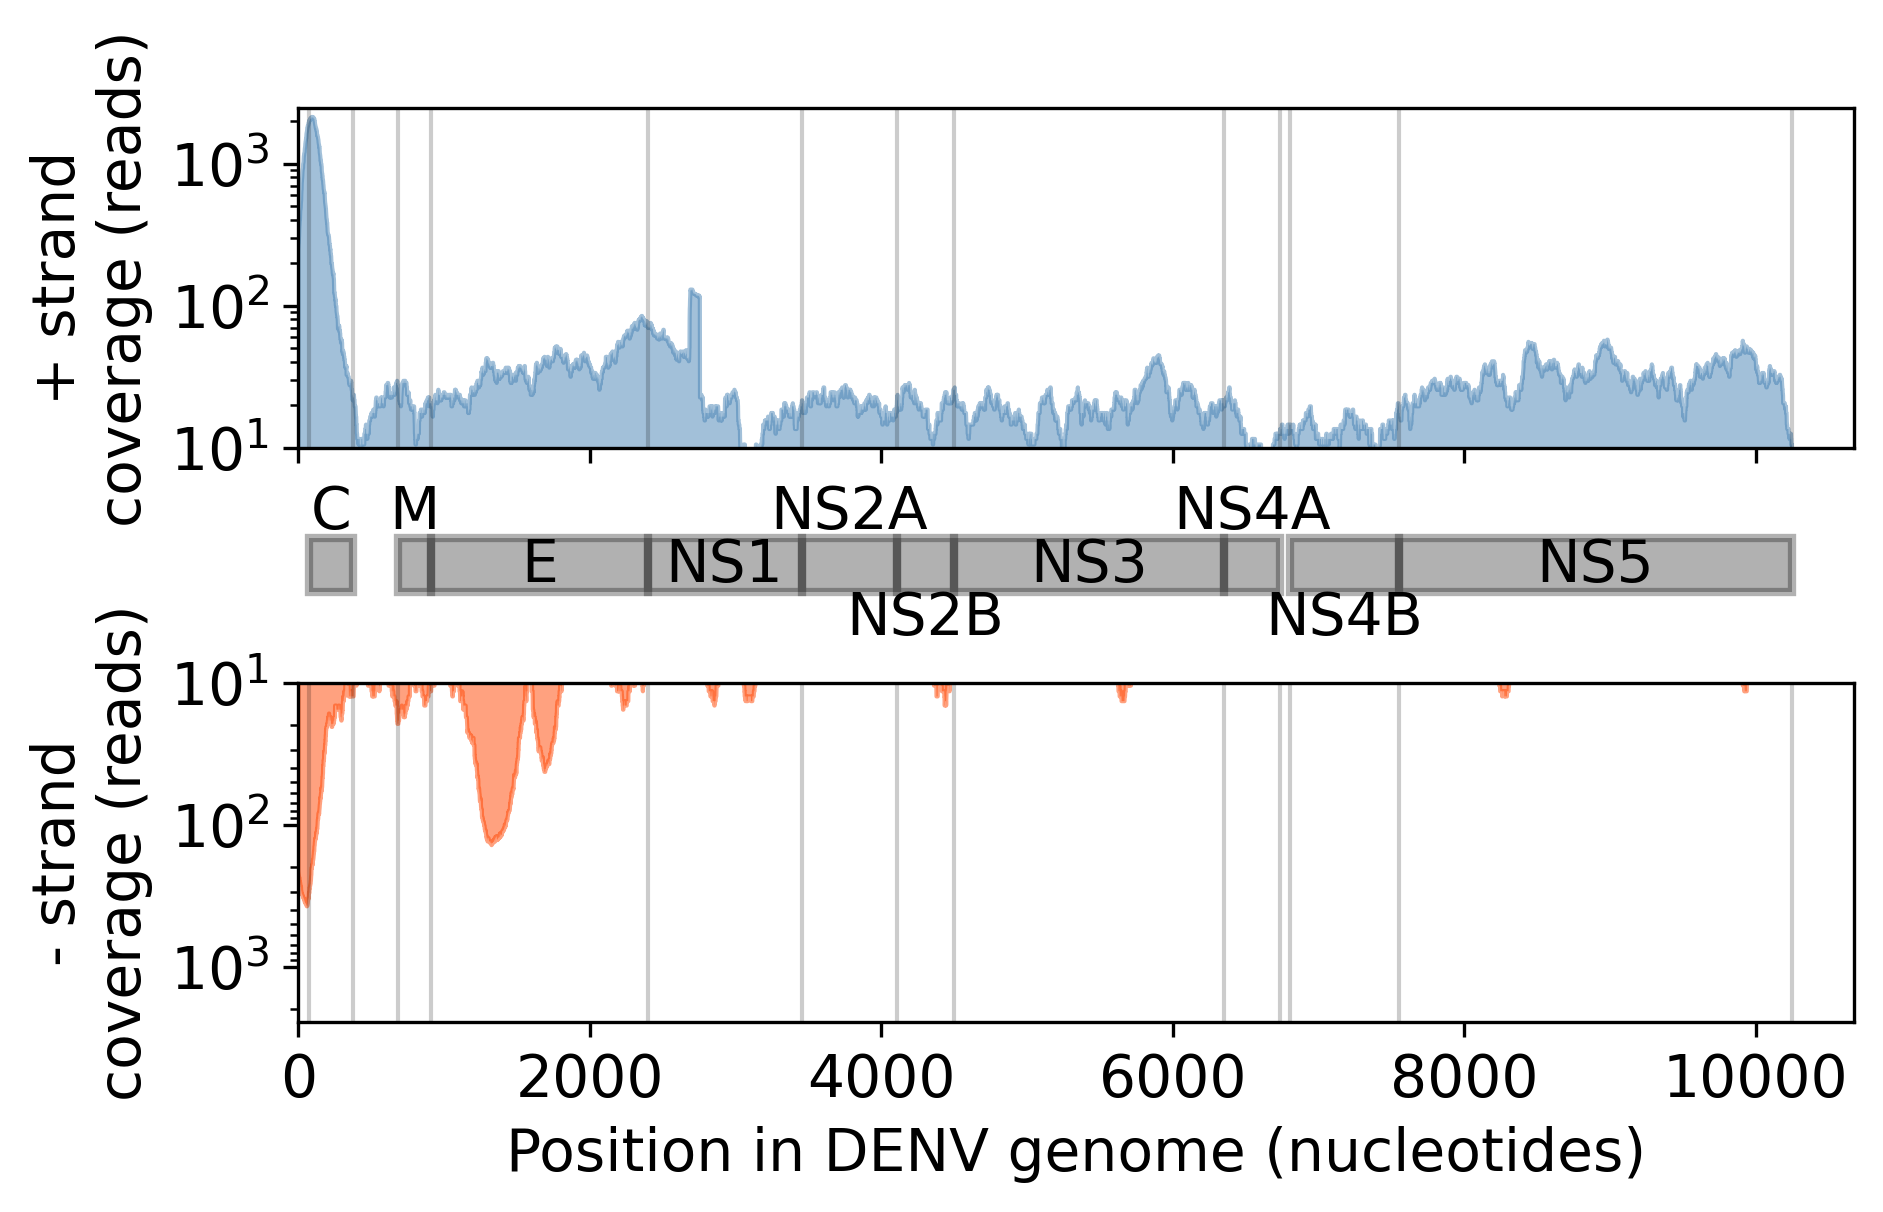

In [6]:
#rcParams['figure.figsize']=(4.5, 4.5)
rcParams['font.size']=14
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['figure.dpi'] = 300

fig, axs = plt.subplots(
        3, 1, figsize=(6.5, 4), sharex=True,
        gridspec_kw={'height_ratios': [5, 1.1, 5]},
        )

# Genome annotation
genome_positions = set()
ax = axs[1]
ax.set_axis_off()
for fea in ref.features:
    if fea.type != 'mat_peptide':
        continue
    name = feature_named.get(fea.qualifiers['product'][0], None)
    if name is None:
        continue
    start, end = fea.location.nofuzzy_start, fea.location.nofuzzy_end
    genome_positions.add(start)
    genome_positions.add(end)
    ax.add_patch(plt.Rectangle(
        (start, 0), end - start, 1, fc='k', ec='k', lw=2, alpha=0.3,
    ))
    yt = 0.5 + int((end - start) < 1000) - 2 * int('B' in name)
    ax.text(0.5 * (start + end), yt, name, ha='center', va='center')
ax.set_ylim(-0.2, 1.2)

# Coverage
x = np.arange(len(coverage[0]))
colors = ['steelblue', 'orangered']
for i, ax in enumerate(axs[::2]):
    ax.fill_between(
            x,
            np.zeros(len(coverage[0])),
            0.5 + coverage[i], color=colors[i], alpha=0.5)
ymax = 1.1 * max(axs[0].get_ylim()[1], axs[1].get_ylim()[1])
for i, ax in enumerate(axs[::2]):
    ax.set_ylim(10, ymax)
    ax.set_yscale('log')
    for pos in genome_positions:
        ax.axvline(pos, lw=1, color='k', alpha=0.2)
    #ax.grid(True)
axs[0].set_ylabel('+ strand\ncoverage (reads)')
axs[-1].set_ylabel('- strand\ncoverage (reads)')
axs[-1].invert_yaxis()
axs[-1].set_xlabel('Position in DENV genome (nucleotides)')
axs[-1].set_xlim(0, len(ref))
fig.tight_layout(h_pad=0)

for ext in ['svg', 'pdf', 'png']:
    kwargs = {}
    if ext == 'png':
        kwargs['dpi'] = 300
    fig.savefig(
        f'{save_figures}coverage_mirrorplot.{ext}',
        **kwargs,
    )

#FIXME: buggy?
if False:
    covdiff = coverage[0] - coverage[1]
    switches = [0] + list((np.diff(covdiff > 0)).nonzero()[0]) + [len(covdiff)]
    fig, ax = plt.subplots(figsize=(6, 3))
    for i in range(len(switches) - 1):
        start, end = switches[i], switches[i+1]
        xi = x[start: end]
        yi = covdiff[start: end]
        color = 'orangered' if yi[0] < 0 else 'steelblue'
        ax.fill_between(xi, np.zeros(len(xi)), yi, color=color, alpha=0.5)
    ax.set_yscale('symlog', linthresh=1000)
    ax.grid(True, axis='x')
    ax.set_xlabel('Position in DENV genome [nucleotides]')
    ax.set_xlim(0, 10500)
    fig.tight_layout()

plt.ion(); plt.show()

In [6]:
patient_names = os.listdir(data_fdn)
bam_fns = glob.glob(data_fdn+'*/*.bam')
    
ratios_all = {}
for bam_fn in bam_fns:
    patient = Path(bam_fn).parent.stem
    molecules = Counter()
    with pysam.AlignmentFile(bam_fn) as bamfile:
        for read in bamfile:
            if (not read.has_tag('CB')) or (not read.has_tag('UB')):
                continue
            strand = '+' if read.is_reverse else '-'
            cell_barcode = read.get_tag('CB')
            umi = read.get_tag('UB')
            molecules[(cell_barcode, umi, strand)] += 1

    molecules = pd.Series(molecules)
    # Collapse UMI
    molecules[:] = 1
    # Conut UMI
    molecules = (molecules.reset_index()
                          .groupby(['level_0', 'level_2'])
                          .sum()
                          .unstack(1, fill_value=0)[0])

    # Find cells with largest #molecules
    cmost = molecules.sum(axis=1).nlargest(50)
    cmost = cmost.loc[cmost >= 8].index

    # Get ratio - / sum
    ratios = 1.0 * (molecules.loc[cmost].T / molecules.loc[cmost].sum(axis=1).values).T['-']

    ratios_all[patient] = ratios

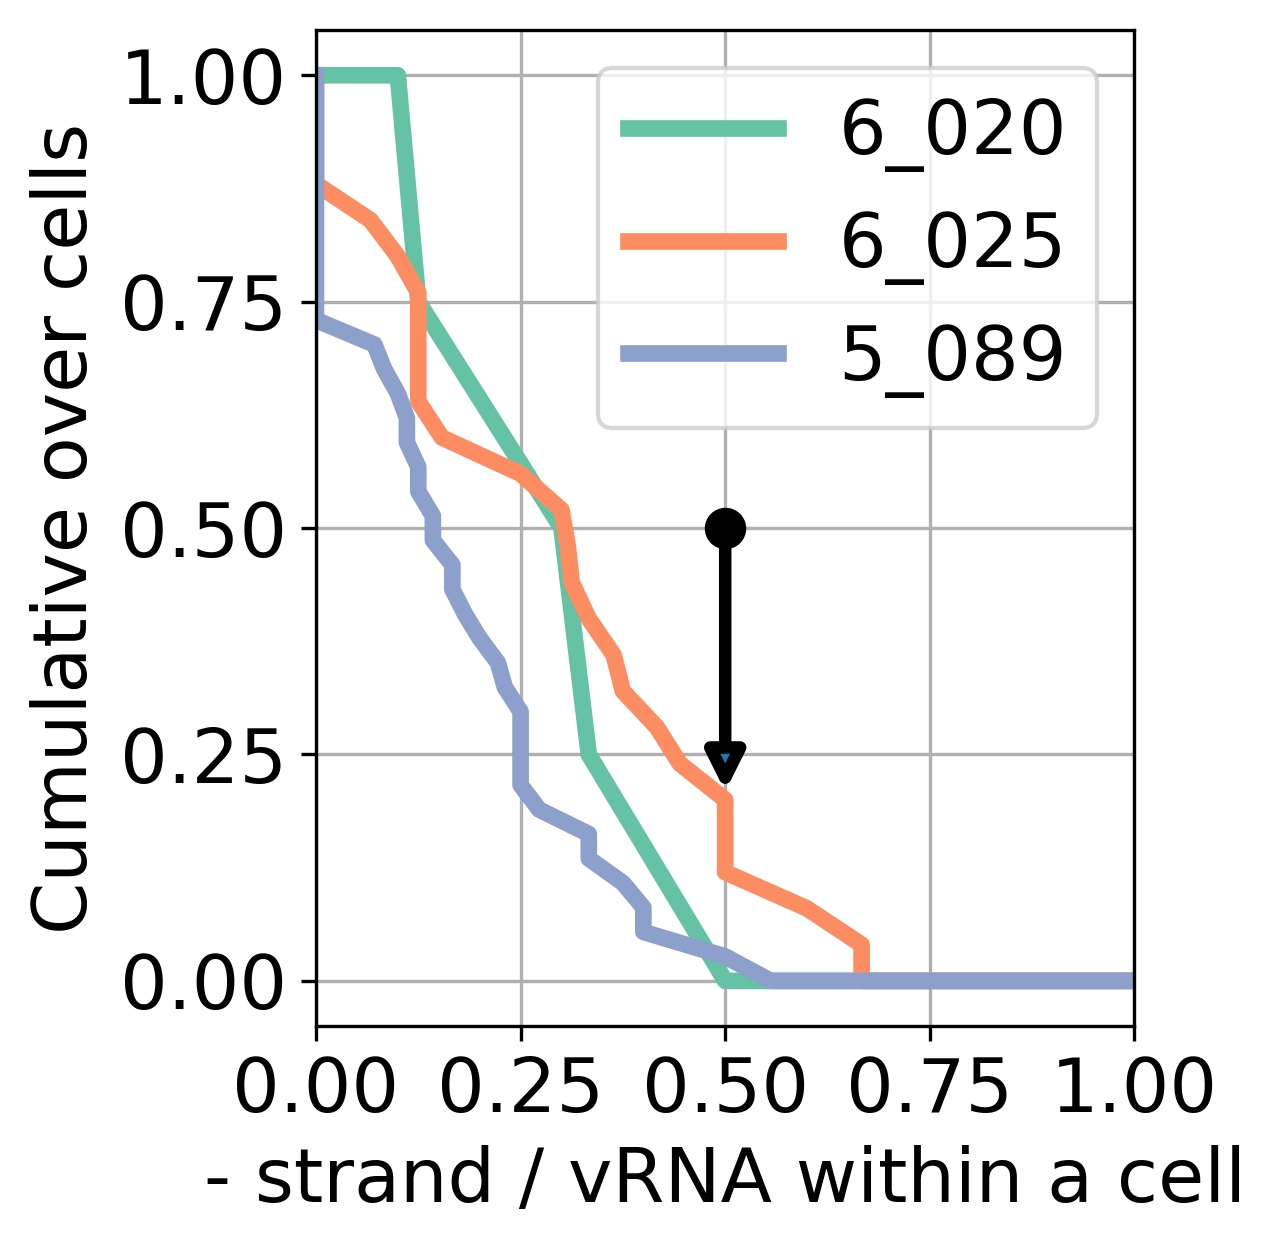

In [25]:
#######################################
rcParams['figure.figsize']=(4.5,4.5)
rcParams['font.size']=18
rcParams['pdf.fonttype'] = 42
rcParams['font.sans-serif'] = "Arial"
rcParams['figure.dpi'] = 300

fig, ax = plt.subplots()
colors = sns.color_palette('Set2', n_colors=3)
for i, (patient, ratios) in enumerate(ratios_all.items()):
    x = list(np.sort(ratios.values))
    y = list(1.0 - np.linspace(0, 1, len(x)))
    x = [0] + x + [1]
    y = [1] + y + [0]
    ax.plot(x, y, label=patient, color=colors[i], lw=4)
ax.legend()
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_yticks([0, 0.25, 0.5, 0.75, 1])
ax.grid(True)
ax.set_xlim(0, 1)
ax.set_xlabel('- strand / vRNA within a cell')
ax.set_ylabel('Cumulative over cells')
ax.annotate(
    '',
    xy=(0.5, 0.2), xytext=(0.5, 0.5),
    arrowprops=dict(arrowstyle='-|>', lw=3),
    zorder=5,
    )
ax.scatter([0.5], [0.5], s=80, color='k', zorder=5)

fig.tight_layout()

plt.ion(); plt.show()
fig.savefig(os.path.join(save_figures, 'coverage_by_cell.png'), bbox_inches='tight')
fig.savefig(os.path.join(save_figures, 'coverage_by_cell.pdf'), bbox_inches='tight')